In [2]:
import os
import pandas as pd
import numpy as np
import time
import pickle
from bagpy import bagreader
import matplotlib.pyplot as plt
import open3d as o3d
import sensor_msgs.point_cloud2 as pc2
from rosbags.image import message_to_cvimage
import pyrealsense2 as rs2
if (not hasattr(rs2, 'intrinsics')):
    import pyrealsense2.pyrealsense2 as rs2

In [3]:
def msgs(bag):
    """For extracting msgs from Rosbag reader

    Returns:
        Dict[str, List]: list of messages and sequences of each kind
    """
    print("Extract messages")
    topic_list = [
        "/camera_left/color/image_raw",
        "/detected_persons/yolo",
        "/front_lidar/velodyne_points"
    ]
    image_msgs = []
    pc_msgs = []
    pers_msgs = []

    for topic, msg, t in bag.read_messages(topics=topic_list):
        
        if topic == "/camera_left/color/image_raw":
            image_msgs.append(msg)

        if topic =="/detected_persons/yolo":
            pers_msgs.append(msg)

        if topic == "/front_lidar/velodyne_points":
            pc_msgs.append(msg)


    bag.close()

    data_params = {
        "image_msgs": image_msgs,
        "pc_msgs": pc_msgs,
        "pers_msgs": pers_msgs,
    }

    return data_params

def create_detection_data(msgs):
    print("Get detection data")
    timestamps = []
    detections = []
    for i in msgs:
        timestamps.append(i.header.stamp.to_time())
        detection = []
        # reduce information about each detection to the necessary things
        for j in i.detections:
            # save from detections: confidence score, positionx, positiony, positionz, bboxx, bboxy, bboxw, bboxh
            conf_score = j.confidence
            pos = [j.pose.pose.position.x, j.pose.pose.position.y, j.pose.pose.position.z]
            bbox = [j.bbox_x, j.bbox_y, j.bbox_w, j.bbox_h]
            detection.append([conf_score, pos, bbox])
        detections.append(detection)
    data = {"timestamps": np.array(timestamps), "detections": detections}
    return data

def create_img_data(msgs):
    print("Get image data")
    timestamps = []
    img_msgs = []
    for i in msgs:
        timestamps.append(i.header.stamp.to_time())
        img = message_to_cvimage(i)
        img_msgs.append(img)
    data = {"timestamps": np.array(timestamps), "img_msgs": img_msgs}
    return data

def pc_to_grid(tmp_msg):
    points_obj = pc2.read_points(tmp_msg, skip_nans=True, field_names=("x", "y", "z"))
    pc = np.array(list(points_obj), dtype=np.float32)
    pc[:,2] = 0
    #print(pc.shape)

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(pc)
    #print(len(pcd.points))

    # fit to unit cube
    pcd.scale(1 / np.max(pcd.get_max_bound() - pcd.get_min_bound()),
            center=pcd.get_center())
    #o3d.visualization.draw_geometries([pcd])
    voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd,
                                                                voxel_size=0.01)
    #o3d.visualization.draw_geometries([voxel_grid])
    voxels = voxel_grid.get_voxels()  # returns list of voxels
    indices = np.stack(list(vx.grid_index for vx in voxels))
    voxel_coord = np.stack(list(voxel_grid.get_voxel_center_coordinate(vx) for vx in indices))
    #print("voxel_coord: ", voxel_coord.shape)
    #print("indices: ", indices)

    return voxel_coord

def create_vox_data(msgs):
    print("Get scene data")
    timestamps = []
    voxel_msgs = []
    for i in msgs:
        timestamps.append(i.header.stamp.to_time())
        vox = pc_to_grid(i)
        voxel_msgs.append(vox)
    data = {"timestamps": np.array(timestamps), "vox_msgs": voxel_msgs}
    return data

def sync_data(d1,d2,d3):
    print("Synchronize data")
    pd.set_option('display.float_format', '{:.2f}'.format)

    df_pers = pd.DataFrame.from_dict(data=d1)
    df_img = pd.DataFrame.from_dict(data=d2)
    df_vox = pd.DataFrame.from_dict(data=d3)

    df_pers.sort_values(by="timestamps",inplace=True)
    df_img.sort_values(by="timestamps",inplace=True)
    df_vox.sort_values(by="timestamps", inplace=True)

    merged_df = pd.merge_asof(df_pers, df_img, on="timestamps", direction="nearest")
    merged_df = pd.merge_asof(merged_df, df_vox, on="timestamps", direction="nearest")

    return merged_df

start_time = time.time()

path = os.path.join("/home/pbr-student/personal/thesis/crowdbot/rosbags_0325_shared_control-rgbd_defaced", "defaced_2021-03-25-14-52-33.orig.bag")
bag = bagreader(path).reader

data_params = msgs(bag)

detect_data = create_detection_data(data_params["pers_msgs"])
img_data = create_img_data(data_params["image_msgs"])
vox_data = create_vox_data(data_params["pc_msgs"])

sync_data = sync_data(detect_data, img_data, vox_data)
sync_data.to_pickle("synced_data.pkl")

[INFO]  Data folder /home/pbr-student/personal/thesis/crowdbot/rosbags_0325_shared_control-rgbd_defaced/defaced_2021-03-25-14-52-33.orig already exists. Not creating.
Extract messages
Get detection data
Get image data
Get scene data
Synchronize data


In [4]:
test_syn_data = sync_data.copy().to_dict()

In [17]:
# get imgs and bboxes
imgs = sync_data.iloc[:500]["img_msgs"]

bboxes = []
scores = []
for d in sync_data.iloc[:500]["detections"]:
    bbox_d = []
    scores_d = []
    for i in d:
        x_min, y_min, w, h = i[2]
        bbox_d.append([int(x_min), int(y_min), int(x_min+w), int(y_min+h)])
        scores_d.append([i[0]])
    bboxes.append(bbox_d)
    scores.append(scores_d)

# BlazePose

In [6]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import numpy as np

# set base options for blazepose
base_options = python.BaseOptions(model_asset_path='pose_landmarker.task')
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=True)
detector = vision.PoseLandmarker.create_from_options(options)

2024-04-18 10:31:16.722648: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-18 10:31:16.793070: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-18 10:31:16.795037: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-18 10:31:17.983362: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
I0000 00:00:1713429079.595917    9054 task_runner.cc:85] GPU suport is not available: INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:77) display != EGL_NO_DISPLAYeglGetDisplay() returned error 0x300c
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [7]:
def draw_landmarks_on_image(rgb_image, detection_result):
  pose_landmarks_list = detection_result.pose_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected poses to visualize.
  for idx in range(len(pose_landmarks_list)):
    pose_landmarks = pose_landmarks_list[idx]

    # Draw the pose landmarks.
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      pose_landmarks_proto,
      solutions.pose.POSE_CONNECTIONS,
      solutions.drawing_styles.get_default_pose_landmarks_style())
  return annotated_image

def get_pose(frame, bbox):
    offset = 0
    #cropped_img = frame.copy()[bbox[1]-offset:bbox[3]+offset, bbox[0]-offset:bbox[2]+offset]
    cropped_img = frame.copy()[bbox[1]:bbox[3], bbox[0]:bbox[2]]
    cropped_img = np.asarray(cropped_img.copy(),dtype=np.uint8)
    cropped_img = frame.copy()
    mp_im = mp.Image(image_format=mp.ImageFormat.SRGB, data=cropped_img)
    detection_result = detector.detect(mp_im)
    annotated_image = draw_landmarks_on_image(cropped_img, detection_result)
    print("detection result: ", detection_result)
    if len(detection_result.pose_landmarks) > 0:
      plt.imshow(annotated_image)
    return detection_result
        

In [20]:
idx = 310
for bbox in bboxes[idx]:
    get_pose(imgs[idx], bbox)

detection result:  PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
detection result:  PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
detection result:  PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
detection result:  PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
detection result:  PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)


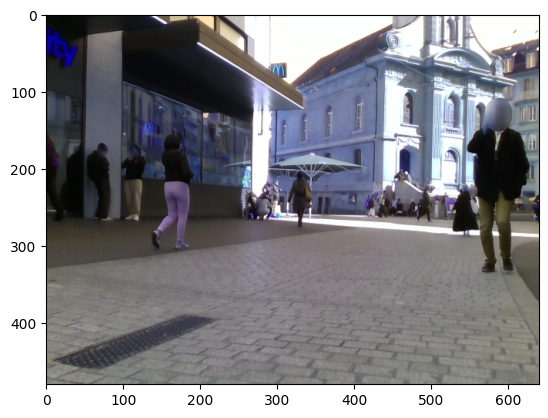

In [21]:
plt.imshow(imgs[idx])

# MoveNet

https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/tutorials/pose_classification.ipynb#scrollTo=QUkOW_26S6K-

In [22]:
import csv
import cv2
import itertools
import numpy as np
import pandas as pd
import os
import sys
import tempfile
import tqdm

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [27]:
pose_sample_rpi_path = os.path.join(os.getcwd(), 'examples/lite/examples/pose_estimation/raspberry_pi')
sys.path.append(pose_sample_rpi_path)
import utils
from data import BodyPart
from ml import Movenet
movenet = Movenet('movenet_thunder')

def detect(input_tensor, inference_count=3):
  """Runs detection on an input image.
 
  Args:
    input_tensor: A [height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.
    inference_count: Number of times the model should run repeatly on the
      same input image to improve detection accuracy.
 
  Returns:
    A Person entity detected by the MoveNet.SinglePose.
  """
  image_height, image_width, channel = input_tensor.shape
 
  # Detect pose using the full input image
  movenet.detect(input_tensor, reset_crop_region=True)
 
  # Repeatedly using previous detection result to identify the region of
  # interest and only croping that region to improve detection accuracy
  for _ in range(inference_count - 1):
    person = movenet.detect(input_tensor, 
                            reset_crop_region=False)

  return person

In [24]:
def draw_prediction_on_image(
    image, person, crop_region=None, close_figure=True,
    keep_input_size=False):
  """Draws the keypoint predictions on image.
 
  Args:
    image: An numpy array with shape [height, width, channel] representing the
      pixel values of the input image.
    person: A person entity returned from the MoveNet.SinglePose model.
    close_figure: Whether to close the plt figure after the function returns.
    keep_input_size: Whether to keep the size of the input image.
 
  Returns:
    An numpy array with shape [out_height, out_width, channel] representing the
    image overlaid with keypoint predictions.
  """
  # Draw the detection result on top of the image.
  image_np = utils.visualize(image, [person])
  
  # Plot the image with detection results.
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  im = ax.imshow(image_np)
 
  if close_figure:
    plt.close(fig)
 
  if not keep_input_size:
    image_np = utils.keep_aspect_ratio_resizer(image_np, (512, 512))

  return image_np

In [55]:
def get_pose2(frame, bbox):
    #offset = 0
    #cropped_img = frame.copy()[bbox[1]-offset:bbox[3]+offset, bbox[0]-offset:bbox[2]+offset]
    cropped_img = frame.copy()[bbox[1]:bbox[3], bbox[0]:bbox[2]]
    cropped_img = np.asarray(cropped_img.copy(),dtype=np.uint8)
    #cropped_img = frame.copy()
    person = detect(cropped_img)

    print("detection result: ", person)
    detections = []
    if len(person.keypoints) > 0:
        output_overlay = draw_prediction_on_image(
              cropped_img.astype(np.uint8), person, 
              close_figure=True, keep_input_size=True)
        output_frame = cv2.cvtColor(output_overlay, cv2.COLOR_RGB2BGR)
        plt.imshow(output_frame)
        for keypoint in person.keypoints:
            detections.append([keypoint.coordinate.x, keypoint.coordinate.y, keypoint.score])
    print(np.asarray(detections).shape)
    return np.asarray(detections)
        



detection result:  Person(keypoints=[KeyPoint(body_part=<BodyPart.NOSE: 0>, coordinate=Point(x=39, y=14), score=0.3622376), KeyPoint(body_part=<BodyPart.LEFT_EYE: 1>, coordinate=Point(x=35, y=11), score=0.52243316), KeyPoint(body_part=<BodyPart.RIGHT_EYE: 2>, coordinate=Point(x=42, y=11), score=0.49357784), KeyPoint(body_part=<BodyPart.LEFT_EAR: 3>, coordinate=Point(x=30, y=14), score=0.5491643), KeyPoint(body_part=<BodyPart.RIGHT_EAR: 4>, coordinate=Point(x=46, y=14), score=0.51042485), KeyPoint(body_part=<BodyPart.LEFT_SHOULDER: 5>, coordinate=Point(x=17, y=40), score=0.7707652), KeyPoint(body_part=<BodyPart.RIGHT_SHOULDER: 6>, coordinate=Point(x=62, y=39), score=0.7646937), KeyPoint(body_part=<BodyPart.LEFT_ELBOW: 7>, coordinate=Point(x=6, y=68), score=0.6759477), KeyPoint(body_part=<BodyPart.RIGHT_ELBOW: 8>, coordinate=Point(x=70, y=72), score=0.60918844), KeyPoint(body_part=<BodyPart.LEFT_WRIST: 9>, coordinate=Point(x=13, y=91), score=0.26772636), KeyPoint(body_part=<BodyPart.RIGH

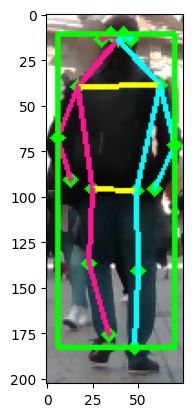

In [57]:
idx = 40
for bbox in bboxes[idx][:1]:
    dets = get_pose2(imgs[idx], bbox)

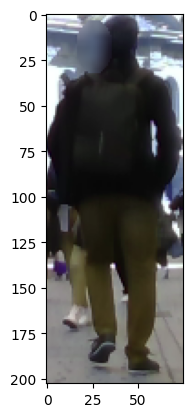

In [51]:
cropped_img = imgs[idx].copy()[bboxes[idx][0][1]:bboxes[idx][0][3], bboxes[idx][0][0]:bboxes[idx][0][2]]
plt.imshow(cropped_img)

# OpenPose
https://github.com/CMU-Perceptual-Computing-Lab/openpose